# Analyze Montage Pegasus workflow expansion

## Global Configurations

In [1]:
notebook_name = "montage-pegasus"

In [2]:
parquet_folder="/p/gpfs1/iopp/recorder_app_logs/montage_pegasus/nodes-32/_parquet"

In [3]:
num_nodes = 32

## System Imports

In [4]:
import socket
import os
import time
from time import sleep

## Create Dask Cluster for analysis

### Dask Job Queue Imports

In [5]:
import dask_jobqueue
from dask_jobqueue import LSFCluster

/usr/workspace/iopp/.conda/envs/jupyter/lib/python3.9/site-packages/dask_jobqueue/core.py:17: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile, get_ip_interface
/usr/workspace/iopp/.conda/envs/jupyter/lib/python3.9/site-packages/dask_jobqueue/core.py:17: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile, get_ip_interface
/usr/workspace/iopp/.conda/envs/jupyter/lib/python3.9/site-packages/dask_jobqueue/htcondor.py:6: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import parse_bytes


### Dask Worker configuration
When we use dask for analysis, we need to consider the type of analysis. In this case we plan to utilize dask dataframes for analysis that is typically memory intensive. Therefore, we allocate the whole memory per node and use only 4 worker processes per node. More worker processes reduce memory available per worker resulting in frequent memory swap from filesystem.

In [6]:
node_memory = 256 # node memory in GB
n_workers_per_node = 4 # number of worker processes per node
worker_time = "02:00" # job time per node for worker
worker_queue = "pdebug" # queue to be used per worker
n_workers = 8 # number of workers to be used for analysis

In [7]:
import sys
python_exe=sys.executable
print(python_exe)

/usr/workspace/iopp/.conda/envs/jupyter/bin/python


Other configurations we can compute

In [8]:
import math
num_nodes = math.ceil(n_workers / n_workers_per_node)
host = socket.gethostname()
dashboard_address = '{}:9787'.format(socket.gethostname())
memory = '{}GB'.format(node_memory/n_workers_per_node)
executable = f"{python_exe}"
job_extra = [f'-nnodes 1', 
             '-G asccasc', 
             '-q {}'.format(worker_queue), 
             '-W {}'.format(worker_time), 
             '-o {}.log'.format(notebook_name), 
             '-e {}.log'.format(notebook_name)]

### Create Dask Cluster 

In [9]:
cluster = LSFCluster(cores = n_workers_per_node,processes=n_workers_per_node, memory='{}GB'.format(node_memory), 
                     header_skip=['-n ','-R','-M', '-P', '-W 00:30'], 
                     job_extra = job_extra, 
                     local_directory="/dev/shm",
                     death_timeout = 500,
                     use_stdin=True, host = host,dashboard_address = dashboard_address,
                     python=executable)
if cluster:
    print("Created Cluster with job script\n {}".format(cluster.job_script()))

{'cls': <class 'distributed.scheduler.Scheduler'>, 'options': {'protocol': 'tcp://', 'interface': None, 'host': 'lassen708', 'dashboard_address': 'lassen708:8787', 'security': None}}
Created Cluster with job script
 #!/usr/bin/env bash

#BSUB -J dask-worker
#BSUB -nnodes 2
#BSUB -G asccasc
#BSUB -q pdebug
#BSUB -W 02:00
#BSUB -o montage-pegasus.log
#BSUB -e montage-pegasus.log
JOB_ID=${LSB_JOBID%.*}

jsrun -n 2 -p 2 -r 1 -c 1 /usr/workspace/iopp/.conda/envs/jupyter/bin/python -m distributed.cli.dask_worker tcp://192.168.66.200:38921 --nthreads 1 --nprocs 4 --memory-limit 59.60GiB --name name --nanny --death-timeout 500 --local-directory /dev/shm



/usr/workspace/iopp/.conda/envs/jupyter/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 35647 instead
  warnings.warn(


### Dask Analysis Imports

In [10]:
import dask.dataframe as dd
from dask.distributed import wait, progress
from dask.diagnostics import ProgressBar
from dask.distributed import Client
import matplotlib.pyplot as plt
import numpy as np
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor

### Create Dask Client

In [11]:
#from dask.distributed import Client, LocalCluster
#cluster = LocalCluster()
client = Client(cluster)

In [12]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.LSFCluster
Dashboard: http://192.168.66.200:35647/status,
Dashboard: http://192.168.66.200:35647/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://192.168.66.200:38921,Workers: 0
Dashboard: http://192.168.66.200:35647/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Spawn cluster nodes

In [13]:
cluster.scale(n_workers)

In [ ]:
val = len(client.scheduler_info()["workers"])
while ((client.status == "running") and ( val < n_workers)):
    print("Waiting for workers completed {} of {}".format(val, n_workers), end="\r")
    sleep(1.0)
    val = len(client.scheduler_info()["workers"])
print("\n{} workers started".format(len(client.scheduler_info()["workers"])))

## Analysis Utility Functions

### Progress Bars

In [14]:
pbar = ProgressBar()
pbar.register()

### Timer functions

In [15]:
def timer(func):
    @functools.wraps(func)
    def wrapper_timer(*args, **kwargs):
        tic = time.perf_counter()
        value = func(*args, **kwargs)
        toc = time.perf_counter()
        elapsed_time = toc - tic
        print(f"Elapsed time: {elapsed_time:0.4f} seconds")
        return value
    return wrapper_timer

### Threading process 

In [16]:
def thread_print(string):
    print(f'{string}\n', end='')
def thread_process( num_ranks, func, start=0, list_range=[], workers=40):
    with ThreadPoolExecutor(max_workers = workers) as executor:
        if len(list_range) == 0:
            list_range = range(start, num_ranks) 
        future_gen = {executor.submit(func, rank): rank for rank in list_range}
        for future in concurrent.futures.as_completed(future_gen):
            rank = future_gen[future]
            try:
                data = future.result()
            except Exception as exc:
                thread_print('%r generated an exception: %s' % (rank, exc))
            else:
                thread_print('%r data computed' % (rank))

### Application Logs in Parquet format

## Initial Boostrapping

### Read Application logs into dask dataframe

In [17]:
ddf = dd.read_parquet("{}/*.parquet".format(parquet_folder), engine="pyarrow-dataset")

In [18]:
print("Dask dataframe is split into {} partitions".format(ddf.npartitions))

Dask dataframe is split into 11360 partitions


In [19]:
print("Columns present in dataset")
print(ddf.columns)

Columns present in dataset
Index(['index', 'proc', 'rank', 'thread_id', 'cat', 'tstart', 'tend',
       'func_id', 'level', 'hostname', 'arg_count', 'app', 'args_1', 'args_2',
       'args_3', 'args_4', 'args_5', 'args_6', 'args_7', 'args_8', 'args_9',
       'args_10'],
      dtype='object')


In [20]:
ddf.dtypes

index          int64
proc           int64
rank           int32
thread_id      int32
cat            int32
tstart       float32
tend         float32
func_id       object
level          int32
hostname      object
arg_count      int32
app           object
args_1        object
args_2        object
args_3        object
args_4        object
args_5        object
args_6        object
args_7        object
args_8        object
args_9        object
args_10       object
dtype: object

In [21]:
ddf.head()

,index,proc,rank,thread_id,cat,tstart,tend,func_id,level,hostname,...,args_1,args_2,args_3,args_4,args_5,args_6,args_7,args_8,args_9,args_10
0,1,120324,0,321552,0,434.451355,434.451477,fopen64,0,lassen76,...,/p/gpfs1/haridev/iopp/montage-workflow/scratch...,rb,,,,,,,,
1,2,120324,0,321552,0,434.451538,434.451752,fread,0,lassen76,...,%p,1,2,/p/gpfs1/haridev/iopp/montage-workflow/scratch...,,,,,,
2,3,120324,0,321552,0,434.451752,434.451782,fclose,0,lassen76,...,/p/gpfs1/haridev/iopp/montage-workflow/scratch...,,,,,,,,,
3,4,120324,0,321552,0,434.451782,434.451813,fopen64,0,lassen76,...,/p/gpfs1/haridev/iopp/montage-workflow/scratch...,rb,,,,,,,,
4,5,120324,0,321552,0,434.451874,434.451904,fread,0,lassen76,...,%p,1,2,/p/gpfs1/haridev/iopp/montage-workflow/scratch...,,,,,,


#### Only keep level zero from MPI and FTRACE but keep all levels for I/O

In [22]:
ddf = ddf[(ddf['level'] == 0) | ddf['cat'].isin([0,1,3])]
#ddf = ddf.persist()

### Split dataframe into I/O, MPI, and trace

In [23]:
io_ddf = ddf[ddf['cat'].isin([0,1,3])]
exclude_dirs = [".pyc", "/usr","/g/g92/haridev/.nccl.conf"]
for directory in exclude_dirs:
    io_ddf = io_ddf[~io_ddf['args_1'].str.contains(directory)]
#io_ddf[rank] = io_ddf[rank].persist()
mpi_ddf = ddf[ddf['cat'] == 2]
#mpi_ddf[rank] = mpi_ddf[rank].persist()
trace_ddf = ddf[ddf['cat'] == 4]

In [24]:
io_ddf = io_ddf.persist()
result = wait(io_ddf)

### Preload the I/O dataframe for faster analysis

In [25]:
io_ddf = io_ddf.persist()
result = wait(io_ddf)

### Check I/O interfaces used by application

In [26]:
interfaces = io_ddf['func_id'].unique().compute()
print(interfaces)

0      fopen64
1        fread
2       fclose
3        fseek
4       remove
5       fwrite
6         pipe
7     vfprintf
8    __xstat64
9       unlink
Name: func_id, dtype: object


Only POSIX interface is used in this application

### Set duration of I/O events

In [27]:
io_ddf['duration'] = io_ddf['tend'] - io_ddf['tstart']

In [28]:
negetive_duration = io_ddf[io_ddf['duration'] < 0]['duration'].count().compute()
print("Application Profiler has stored {} negetive values".format(negetive_duration))

Application Profiler has stored 0 negetive values


### Create conditions for filtering
Even though this application doesnt have MPI or STDIO we have all the conditions here. This is to make sure we cover other apps as well.

In [29]:
open_condition = io_ddf['func_id'].str.contains("open")
mpi_condition = io_ddf['func_id'].str.contains("MPI")
read_condition = io_ddf['func_id'].isin(["read", "pread", "pread64", "readv"])
fread_condition = io_ddf['func_id'].isin(["fread"])
close_condition = io_ddf['func_id'].str.contains('close')
write_condition = io_ddf['func_id'].isin(["write", "pwrite", "pwrite64","writev"])
fwrite_condition = io_ddf['func_id'].isin(["fwrite"])
readdir_condition = io_ddf['func_id'].isin(["readdir"])

### Extract Filename from each row.
This simplifies analysis later on as we can filter recorder per rank and per file to understand access pattern information.

In [30]:
io_ddf['filename'] = ""
io_ddf['filename'] = io_ddf['filename'].mask(open_condition & ~mpi_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(open_condition & mpi_condition, io_ddf['args_2'])
io_ddf['filename'] = io_ddf['filename'].mask(close_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(read_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(fread_condition, io_ddf['args_4'])
io_ddf['filename'] = io_ddf['filename'].mask(write_condition, io_ddf['args_1'])
io_ddf['filename'] = io_ddf['filename'].mask(fwrite_condition, io_ddf['args_4'])

Some filename has redundent forward slashes

In [31]:
io_ddf['filename'] = io_ddf['filename'].str.replace('//','/')

### Filter recorder which have read and write operations and which have metadata.
We assume that there is only two types of operation in I/O read/write and metadata.

In [32]:
io_ddf_read_write = io_ddf[read_condition | write_condition | fread_condition | fwrite_condition].compute()
io_ddf_metadata = io_ddf[~(read_condition | write_condition | fread_condition | fwrite_condition)].compute()

### Build size and count to understand I/O on the io_ddf_read_write dataframe

In [33]:
open_condition = io_ddf_read_write['func_id'].str.contains("open")
mpi_condition = io_ddf_read_write['func_id'].str.contains("MPI")
read_condition = io_ddf_read_write['func_id'].isin(["read", "pread", "pread64", "readv"])
fread_condition = io_ddf_read_write['func_id'].isin(["fread"])
close_condition = io_ddf_read_write['func_id'].str.contains('close')
write_condition = io_ddf_read_write['func_id'].isin(["write", "pwrite", "pwrite64","writev"])
fwrite_condition = io_ddf_read_write['func_id'].isin(["fwrite"])
readdir_condition = io_ddf_read_write['func_id'].isin(["readdir"])

In [34]:
io_ddf_read_write['size'] = 0
io_ddf_read_write['count'] = 1
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(read_condition , io_ddf_read_write['args_3'])
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(fread_condition, io_ddf_read_write['args_3'])
io_ddf_read_write['count'] = io_ddf_read_write['count'].mask(fread_condition, io_ddf_read_write['args_2'])
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(write_condition, io_ddf_read_write['args_3'])
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(fwrite_condition, io_ddf_read_write['args_3'])
io_ddf_read_write['count'] = io_ddf_read_write['count'].mask(fwrite_condition, io_ddf_read_write['args_2'])

#### Corner cases

In [35]:
io_ddf_read_write['size'] = io_ddf_read_write['size'].mask(readdir_condition , "0")
io_ddf_read_write['count'] = io_ddf_read_write['count'].mask(readdir_condition , "1")

#### Set Datatypes
This is needed as by default args are string from which they are set.

In [36]:
io_ddf_read_write = io_ddf_read_write.astype({'size': 'int32','count': 'int32'})

#### Compute Final Size
After this point we do not use count field.

In [37]:
io_ddf_read_write['size'] = io_ddf_read_write['size'] * io_ddf_read_write['count']

### Calculate Bandwidth in MB/s for I/O operations.
Durations might be incorrect or equal to zero due to profilers resolution issues. Therefore, we do bandwidth calculations for only correct durations.

In [38]:
correct_dur = ((io_ddf_read_write['tend'] - io_ddf_read_write['tstart']) > 0)
io_ddf_read_write['bandwidth'] = 0
io_ddf_read_write['bandwidth'] = io_ddf_read_write['bandwidth'].mask(correct_dur, io_ddf_read_write['size']*1.0/(io_ddf_read_write['tend'] - io_ddf_read_write['tstart'])/1024.0/1024.0)

### Calculate all relevent filenames in the application
The profiler might see jsrun files and other irrelevant internal files which we filter here.

In [39]:
all_filenames = io_ddf[io_ddf['filename'].str.contains('/p/gpfs1')]['filename'].unique().compute()

In [40]:
print("The application accesses {} files across all ranks".format(len(all_filenames)))

The application accesses 5738 files across all ranks


In [41]:
io_ddf_read_write.head()

,index,proc,rank,thread_id,cat,tstart,tend,func_id,level,hostname,...,args_6,args_7,args_8,args_9,args_10,duration,filename,size,count,bandwidth
1,2,120324,0,321552,0,434.451538,434.451752,fread,0,lassen76,...,,,,,,0.000214,/p/gpfs1/haridev/iopp/montage-workflow/scratch...,2,1,0.008929
4,5,120324,0,321552,0,434.451874,434.451904,fread,0,lassen76,...,,,,,,0.000031,/p/gpfs1/haridev/iopp/montage-workflow/scratch...,2,1,0.062500
7,8,120324,0,321552,0,434.454681,434.454681,fread,0,lassen76,...,,,,,,0.000000,/p/gpfs1/haridev/iopp/montage-workflow/scratch...,4,1,0.000000
9,10,120324,0,321552,0,434.454742,434.454773,fread,0,lassen76,...,,,,,,0.000031,/p/gpfs1/haridev/iopp/montage-workflow/scratch...,32768,1,1024.000000
10,11,120324,0,321552,0,434.455536,434.455566,fread,0,lassen76,...,,,,,,0.000031,/p/gpfs1/haridev/iopp/montage-workflow/scratch...,32768,1,1024.000000


### Distribution of Transfer Size and Bandwidth in the application
The transfer size is given by the size column in bytes and the bandwidth is shown in MB/s

In [42]:
io_ddf_read_write[['size', 'bandwidth']].describe()

,size,bandwidth
count,1.100839e+07,1.100839e+07
mean,1.356242e+04,5.171620e+02
std,1.604083e+04,6.582878e+02
min,2.000000e+00,0.000000e+00
25%,2.880000e+03,0.000000e+00
50%,1.728000e+04,5.487805e-01
75%,2.060000e+04,1.080000e+03
max,3.291618e+07,1.028371e+04


### Preload the I/O dataframe for faster analysis

In [43]:
io_ddf = io_ddf.persist()
result = wait(io_ddf)

### Operations Per Application

In [44]:
io_ddf.groupby(['app','func_id'])['func_id'].count().compute()

app          func_id  
mProject     fclose          2197
             fopen64         2535
             fread          69984
             fseek           1014
             fwrite       1661266
             remove           338
mDiffFit     fopen64        10221
             pipe           11484
             vfprintf        5321
mDiff        fclose         69088
             fopen64        69928
             fread        4401056
             fwrite       1907844
             remove           840
mFitplane    fclose           832
             fopen64          832
             fread         857791
mBackground  __xstat64        216
             fclose          1296
             fopen64         1512
             fread         518306
             fseek            216
             fwrite       1046902
             remove           216
mConcatFit   __xstat64       4034
             fclose          4032
             fopen64         4036
             fseek              2
             fwrite      

In [47]:
io_ddf_read_write.groupby(['app','func_id'])['size'].sum() /1024.0/1024.0

app          func_id
mAdd         fread       6074.015217
             fwrite      1582.042236
mBackground  fread       9547.493118
             fwrite      9547.058716
mBgModel     fwrite         0.000107
mConcatFit   fwrite         0.000399
mDiff        fread      85396.764038
             fwrite      7024.828491
mFitplane    fread       3412.809341
mImgtbl      fread          0.351807
             fwrite         0.000982
mProject     fread       2137.361164
             fwrite     15228.347168
mViewer      fread       2373.057869
             fwrite        59.754055
Name: size, dtype: float64

In [130]:
io_ddf_read_write.groupby(['app'])['proc'].nunique() 

app
mAdd              2
mBackground     108
mBgModel          2
mConcatFit        2
mDiff          5271
mFitplane       415
mImgtbl           2
mProject        169
mViewer           2
Name: proc, dtype: int64

## Application Analysis

In [48]:
rank_index_series = io_ddf_read_write.groupby(['hostname','app','proc','rank', 'thread_id'])['thread_id'].nunique().cumsum()
#io_ddf_read_write['rank_index'] = 0
#for index,item in rank_index_series.iteritems():
#    condition = (io_ddf_read_write['hostname'] == index[0]) & (io_ddf_read_write['app'] == index[1]) & (io_ddf_read_write['proc'] == index[2]) & (io_ddf_read_write['rank'] == index[3]) & (io_ddf_read_write['thread_id'] == index[4])
#    io_ddf_read_write['rank_index'] = io_ddf_read_write['rank_index'].mask(condition , item - 1)

### Num Ranks

In [49]:
num_ranks = rank_index_series.nunique()
print("Number of ranks in application {}".format(num_ranks))

Number of ranks in application 6039


### Total I/O amount

In [50]:
total_io = io_ddf_read_write.groupby('func_id')['size'].sum()/1024.0/1024.0/1024.0
print("Total I/O in application {} GB".format(total_io.sum()))
print("Total I/O per operation in application {} GB".format(total_io))

Total I/O in application 139.0467624105513 GB
Total I/O per operation in application func_id
fread     106.388528
fwrite     32.658235
Name: size, dtype: float64 GB


### I/O per rank

In [51]:
io_ddf_read_write.groupby(['rank', 'func_id'])['size'].sum()

rank  func_id
0     fread      1.142338e+11
      fwrite     3.506651e+10
Name: size, dtype: float64

**rank 0 performs 100x more I/O than others. Also every other process reads data where as only rank 0 writes it.**

<AxesSubplot:xlabel='app'>

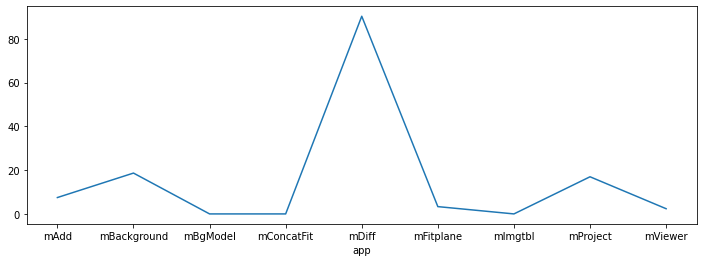

In [52]:
io_per_rank_gb = io_ddf_read_write.groupby(['app'])['size'].sum()/1024.0/1024.0/1024.0
io_per_rank_gb.plot(kind='line',figsize=(12,4))

### Operations Per Rank

<AxesSubplot:xlabel='app'>

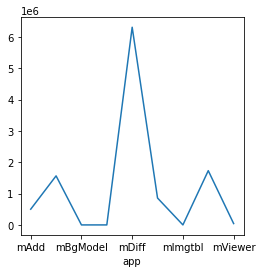

In [53]:
io_per_rank_gb = io_ddf_read_write.groupby(['app'])['count'].sum()
io_per_rank_gb.plot(kind='line',figsize=(4,4))

**Also rank 0 performs 2000x more operations than other ranks.**

### Average I/O Time per process

In [54]:
time_per_rank = io_ddf.groupby('app')['duration'].sum().compute()

In [55]:
print("time per process: Average {} sec, Max {} sec, and Min {} sec".format(time_per_rank.mean(), time_per_rank.max(), time_per_rank.min()))

time per process: Average 21.83269691467285 sec, Max 136.9674072265625 sec, and Min 0.00235748291015625 sec


<AxesSubplot:xlabel='app'>

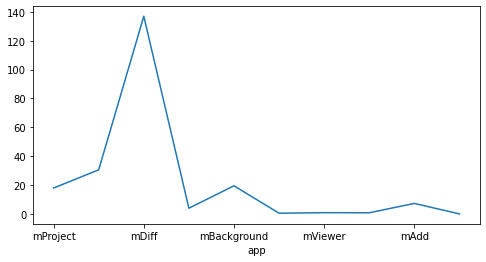

In [56]:
time_per_rank.plot(kind='line',figsize=(8,4))

Most time is spent by rank 0.

### Compute Time

#### Convert trace dataframe into memory.

In [57]:
trace_ddf_local = trace_ddf

#### Calculate duration for trace values

In [58]:
trace_ddf_local['duration'] = trace_ddf_local['tend'] - trace_ddf_local['tstart']

In [59]:
trace_ddf_local['duration'].describe().compute()

ValueError: No non-trivial arrays found

In [60]:
negetive_durations = trace_ddf_local[trace_ddf_local['duration'] < 0]['duration'].count().compute()
print("Profiler stored {} negetive rows".format(negetive_durations))

Profiler stored 0 negetive rows


In [61]:
time_per_rank = trace_ddf_local.groupby('app')['duration'].sum().compute()

In [62]:
print("Time per process: Average {} sec, Max {} sec, and Min {} sec".format(time_per_rank.mean(), time_per_rank.max(), time_per_rank.min()))

Time per process: Average nan sec, Max nan sec, and Min nan sec


<AxesSubplot:xlabel='app'>

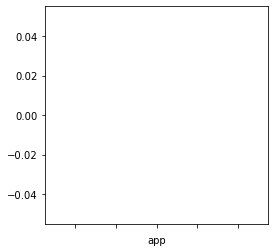

In [63]:
time_per_rank.plot(kind='line',figsize=(4,4))

**No compute trace available**

## Job Time

In [64]:
job_time = ddf['tend'].max().compute()

In [65]:
print("Job Time in Application {} sec".format(job_time))

Job Time in Application 29283.2265625 sec


The application run for a long time includes initialization.

## Job Intensity

In [66]:
total_compute = trace_ddf_local['duration'].sum().compute()
total_io = io_ddf['duration'].sum().compute()
print("I/O Time: {} sec Compute Time: {} sec".format(total_io, total_compute))

I/O Time: 218.32693481445312 sec Compute Time: 0.0 sec


In [67]:
io_intensity=total_io/(total_io + total_compute)
comp_intensity=total_compute/(total_io + total_compute)

In [68]:
print("I/O intensity: {}, Compute intensity: {}".format(io_intensity, comp_intensity))

I/O intensity: 1.0, Compute intensity: 0.0


**Application is not compute intensive as only 4 second of the overall time (i.e. 668 sec) is spent on I/O**

### I/O Transfer Size Distribution

[4098639, 6909746, 0, 0, 2]


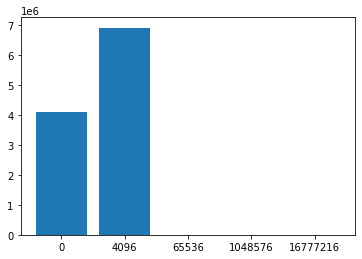

In [69]:
file_df_temp = io_ddf_read_write
size_ranges = [0, 4*1024, 64*1024, 1024*1024, 16*1024*1024]
size_ranges_str = []
for range_val in size_ranges:
    size_ranges_str.append(str(range_val))
max_range = len(size_ranges)
request_size = [0]*len(size_ranges)
for i, val in enumerate(size_ranges):
    #print(i, max_range)
    if i < max_range - 1:
        request_size[i] = file_df_temp[(file_df_temp['size'].ge(val)) & 
                                       (file_df_temp['size'].lt(size_ranges[i+1]))]['size'].count()
    else:
        request_size[i] = file_df_temp[(file_df_temp['size'] >=size_ranges[i])]['size'].count()

print(request_size)
plt.bar(size_ranges_str, request_size)
#file_sizes = file_df_temp['size'].to_numpy() / 1024.0 /1024.0
#plt.hist(file_sizes, bins=100)
plt.show()

**Application performs a lot of small I/O <=4 KB and reads 16MB**

### Distribution of request sizes per rank
We need this as we see most I/O occurs by rank 0

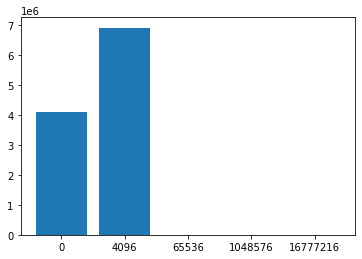

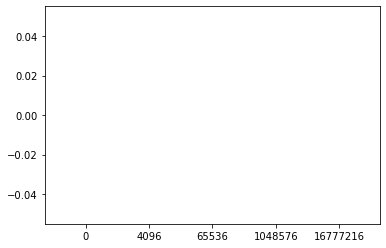

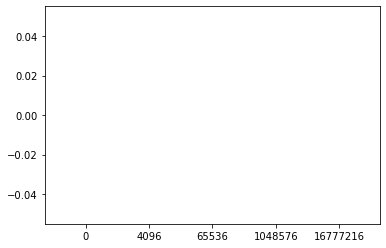

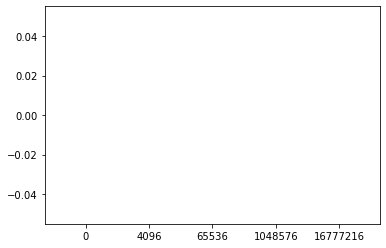

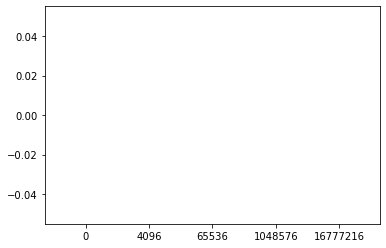

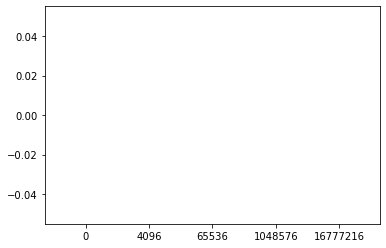

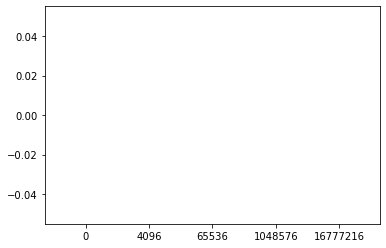

In [70]:
selected_ranks = [0,1,2,3,4,5,6]
for rank in selected_ranks:
    file_df_temp = io_ddf_read_write[io_ddf_read_write['rank'] == rank]
    size_ranges = [0, 4*1024, 64*1024, 1024*1024, 16*1024*1024]
    size_ranges_str = []
    for range_val in size_ranges:
        size_ranges_str.append(str(range_val))
    max_range = len(size_ranges)
    request_size = [0]*len(size_ranges)
    for i, val in enumerate(size_ranges):
        #print(i, max_range)
        if i < max_range - 1:
            request_size[i] = file_df_temp[(file_df_temp['size'].ge(val)) & 
                                           (file_df_temp['size'].lt(size_ranges[i+1]))]['size'].count()
        else:
            request_size[i] = file_df_temp[(file_df_temp['size'] >=size_ranges[i])]['size'].count()

    #print(request_size)
    plt.bar(size_ranges_str, request_size)
    #file_sizes = file_df_temp['size'].to_numpy() / 1024.0 /1024.0
    #plt.hist(file_sizes, bins=100)
    plt.show()

**The application uses a transfer size of 4K (used by rank 0) and 16MB (used by other ranks)**

### Distribution of Bandwidth achived by application

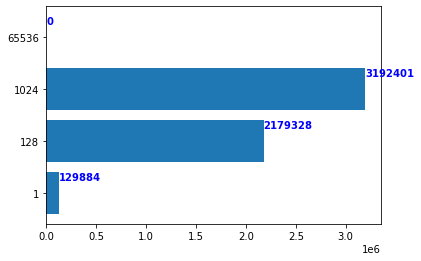

In [71]:
bw_ranges = [1, 128, 1024, 1024*64]
bw_ranges_str = []
for range_val in bw_ranges:
    bw_ranges_str.append(str(range_val))
max_range = len(bw_ranges)
request_bw = [0]*len(bw_ranges)
file_df_temp = io_ddf_read_write
for i, val in enumerate(bw_ranges):
    #print(i, max_range)
    if i < max_range - 1:
        request_bw[i] = file_df_temp[(file_df_temp['bandwidth'].ge(val)) & 
                                       (file_df_temp['bandwidth'].lt(bw_ranges[i+1]))]['size'].count()
    else:
        request_bw[i] = file_df_temp[(file_df_temp['bandwidth'] >=bw_ranges[i])]['size'].count()
fig, ax = plt.subplots()
ax.barh(bw_ranges_str, request_bw)
for i, v in enumerate(request_bw):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')
plt.show()

In [72]:
request_bw

[129884, 2179328, 3192401, 0]

In [73]:
percentage_bw = np.array(request_bw)*100/np.sum(request_bw)
percentage_bw

array([ 2.3608349 , 39.61252818, 58.02663692,  0.        ])

- 40% of the overall I/O got a bandwidth of 128 MB/s per process.
- 35% achieve a low bandwidth of 64GB/s

0.2597526443282433 93.10350284793765


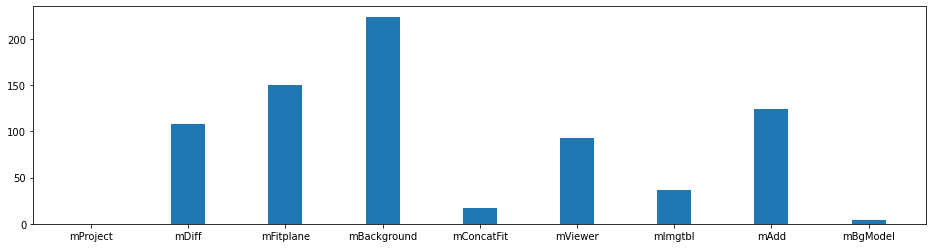

11.306575355904743 nan


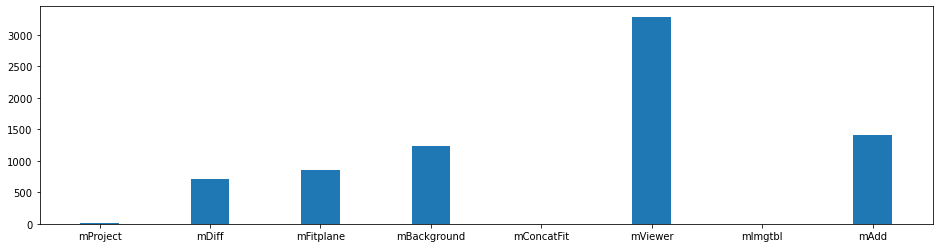

nan nan


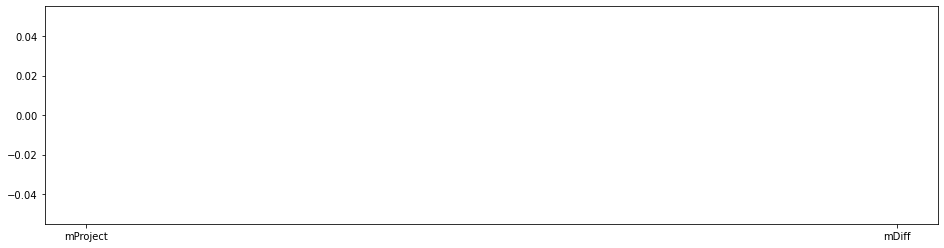

nan nan


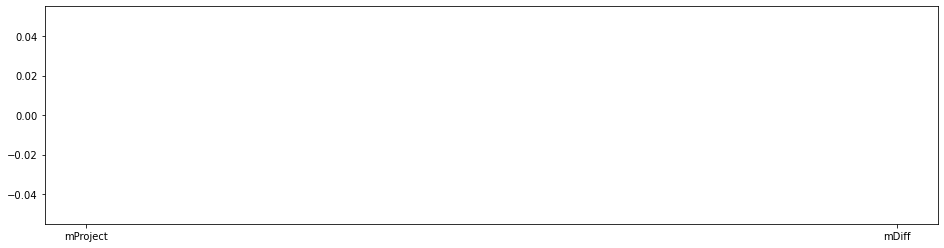

nan nan


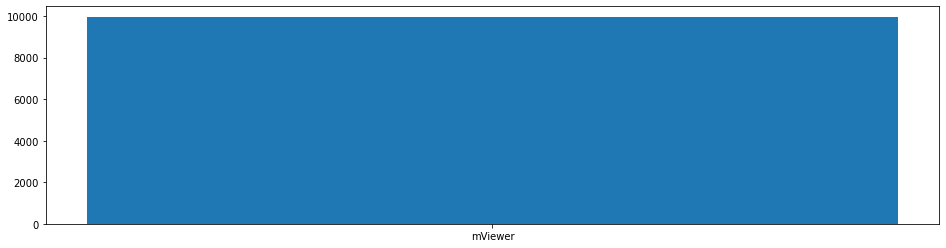

No handles with labels found to put in legend.


In [122]:
app_str = io_ddf_read_write['app'].unique()
size_ranges = [0, 4*1024, 64*1024, 1024*1024, 16*1024*1024]
request_size = [[]]*len(size_ranges)
for i, val in enumerate(size_ranges):
    request_size[i] = [0]*len(app_str)
    for j,app in enumerate(app_str):
        
        file_df_temp = io_ddf_read_write[io_ddf_read_write['app'] == app]
        max_range = len(size_ranges)
        if i < max_range - 1:
            request_size[i][j] = file_df_temp[(file_df_temp['size'].ge(val)) & 
                                           (file_df_temp['size'].lt(size_ranges[i+1]))]['bandwidth'].mean()
        else:
            request_size[i][j] = file_df_temp[(file_df_temp['size'] >=size_ranges[i])]['bandwidth'].mean()
#fig, ax = plt.subplots(figsize=(16,4))
#width = 0.35
#plt.figure()
for i, val in enumerate(size_ranges):
    plt.figure(figsize=(16,4))
    print(request_size[i][0],np.median(request_size[i]))
    rects1 = plt.bar(app_str, request_size[i], 0.35, label=str(i))
    plt.show()
ax.legend()

fig.tight_layout()

plt.show()

### Number of files read/written

In [75]:
all_filenames = io_ddf[io_ddf['filename'].str.contains('/p/gpfs1')]['filename'].unique().compute()
print("The application accesses {} files".format(len(all_filenames)))
#print(all_filenames[:8],all_filenames[-8:])

The application accesses 5738 files


### I/O Operations by Application

In [76]:
io_ddf.groupby('func_id')['func_id'].count().compute()

func_id
fclose         78029
fopen64        89690
fread        6219551
fseek           1240
fwrite       4788836
remove          1398
pipe           11484
vfprintf        9476
__xstat64       4516
unlink             2
Name: func_id, dtype: int64

**As there are 1280 ranks in total, Most I/O is performed by rank 0 rest of them do less I/O**

### IO Operations per rank

In [77]:
io_ddf.groupby(['rank','func_id'])['func_id'].count().compute()[:32]

rank  func_id  
0     fclose         78029
      fopen64        89690
      fread        6219551
      fseek           1240
      fwrite       4788836
      remove          1398
      pipe           11484
      vfprintf        9476
      __xstat64       4516
      unlink             2
Name: func_id, dtype: int64

In [78]:
io_ddf.groupby(['rank','func_id'])['func_id'].count().compute()[128:160]

Series([], Name: func_id, dtype: int64)

**These confirm our hypothesis that most I/O is performed by rank 0 rest of them do less I/O**

### Bandwidth per request distribution
We calculate the achived bandwidth per request size.

756.8217778193199


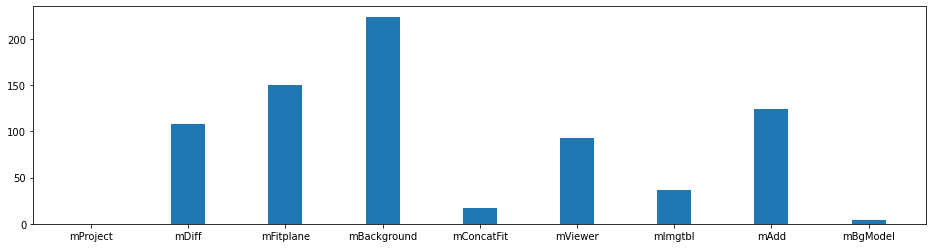

nan


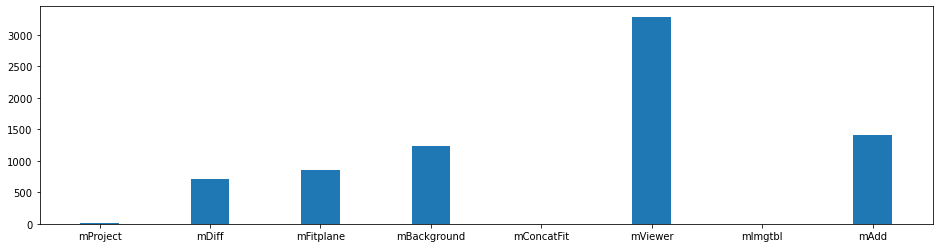

nan


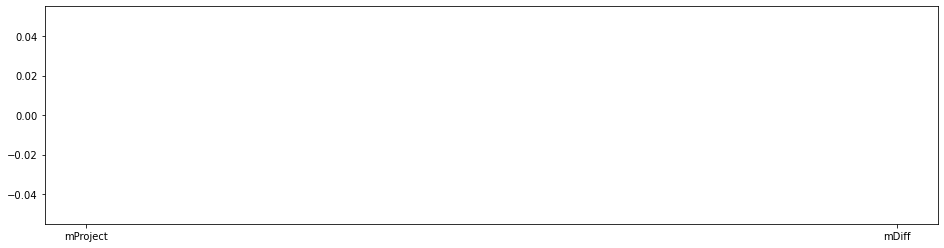

nan


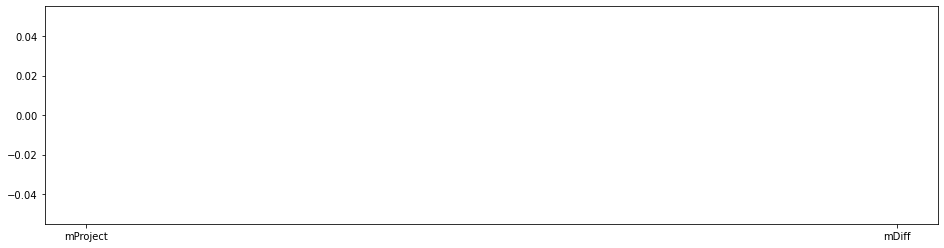

nan


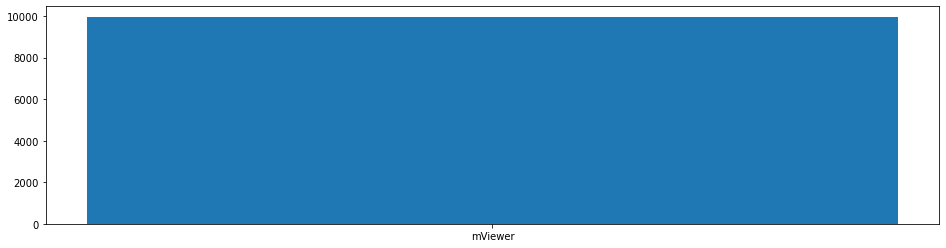

No handles with labels found to put in legend.


In [79]:
app_str = io_ddf_read_write['app'].unique()
size_ranges = [0, 4*1024, 64*1024, 1024*1024, 16*1024*1024]
request_size = [[]]*len(size_ranges)
for i, val in enumerate(size_ranges):
    request_size[i] = [0]*len(app_str)
    for j,app in enumerate(app_str):
        
        file_df_temp = io_ddf_read_write[io_ddf_read_write['app'] == app]
        max_range = len(size_ranges)
        if i < max_range - 1:
            request_size[i][j] = file_df_temp[(file_df_temp['size'].ge(val)) & 
                                           (file_df_temp['size'].lt(size_ranges[i+1]))]['bandwidth'].mean()
        else:
            request_size[i][j] = file_df_temp[(file_df_temp['size'] >=size_ranges[i])]['bandwidth'].mean()
#fig, ax = plt.subplots(figsize=(16,4))
#width = 0.35
#plt.figure()
for i, val in enumerate(size_ranges):
    plt.figure(figsize=(16,4))
    print(np.sum(request_size[i]))
    rects1 = plt.bar(app_str, request_size[i], 0.35, label=str(i))
    plt.show()
ax.legend()

fig.tight_layout()

plt.show()

**Larger Request sizes have larger bandwidth. However as 4KB write dominates the application I/O we see small bandwidth overall**

### Overlapping of Compute and I/O

In [80]:
io_ddf.groupby('proc')['thread_id'].nunique().describe().compute()

count    11107.000000
mean         1.011164
std          0.105074
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: thread_id, dtype: float64

#### No additional threads means I/O is synchronous to compute. I.e. all I/O is unoverlapped.

### Timeline
The timeline analysis shows how each rank performs I/O over the runtime of the applications

In [81]:
time_step=100 # in seconds

#### Request Size Timeline

[0.0, 58.95488303806633, 13.324632291682065, 7.572678279131651, 8.832125531509519, 8.170321276411414, 6.7905617374926805, 4.355286046862602, 4.381600039079785, 2.8905502166599035, 1.51368841342628, 0.7026475183665752, 1.7805053312331438, 1.2000648006796837, 0.9258297104388475, 0.9169784169644117, 0.43755616806447506, 0.4135808143764734, 0.1114856656640768, 0.22270905412733555, 0.0, 0.0, 0.11200382001698017, 0.22250964306294918, 0.0397099070250988, 0.0, 0.06520165503025055, 0.11174261011183262, 0.11182617396116257, 0.0, 0.06457571499049664, 0.0, 0.222181748598814, 0.0, 0.06403366103768349, 0.0, 0.2208544034510851, 0.0, 0.06567957438528538, 0.0, 0.11244171671569347, 0.10947230830788612, 0.10935628414154053, 0.0, 0.0, 0.288909375667572, 0.0, 0.06473850645124912, 0.0, 0.11002311669290066, 0.0675350483506918, 0.10918926820158958, 0.06455823220312595, 0.0, 0.11199767701327801, 0.10984469950199127, 0.10921320877969265, 0.0, 0.10968359559774399, 0.0, 0.1764567457139492, 0.0, 0.0653690565377473

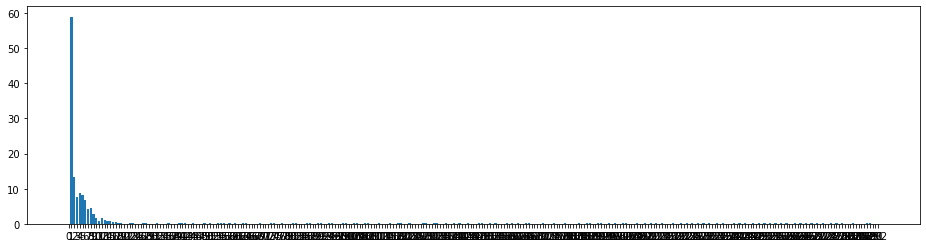

In [123]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
values_str = []
timeline_ts = [0]*len(values_int)
prev = 0
for i in values_int:
    values_str.append(str(i))
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i])
    timeline_ts[i] = io_ddf_read_write[contains]['size'].sum()/1024.0/1024.0/1024.0
    prev = values[i]
plt.figure(figsize=(16,4))
print(timeline_ts)
plt.bar(values_str, timeline_ts)
plt.show()

[0.0, 45.96334859728813, 12.365868017077446, 7.096178483217955, 8.139166103675961, 7.1780219580978155, 6.231696667149663, 3.945948764681816, 3.997883217409253, 2.628385743126273, 1.2500272672623396, 0.6494324915111065, 1.602921636775136, 1.012964628636837, 0.8212450165301561, 0.8098241668194532, 0.39953317306935787, 0.39632884599268436, 0.012560432776808739, 0.024472350254654884, 0.0, 0.0, 0.012960569933056831, 0.025689145550131798, 0.010929804295301437, 0.0, 0.012265577912330627, 0.012817377224564552, 0.013088695704936981, 0.0, 0.011108560487627983, 0.0, 0.024631690233945847, 0.0, 0.01111367717385292, 0.0, 0.023840786889195442, 0.0, 0.012743497267365456, 0.0, 0.012668905779719353, 0.011426839977502823, 0.010581254959106445, 0.0, 0.0, 0.03750056028366089, 0.0, 0.0114054623991251, 0.0, 0.012015199288725853, 0.014223461970686913, 0.011294003576040268, 0.011171543970704079, 0.0, 0.012916876003146172, 0.011949434876441956, 0.011242842301726341, 0.0, 0.011906348168849945, 0.0, 0.02562540397

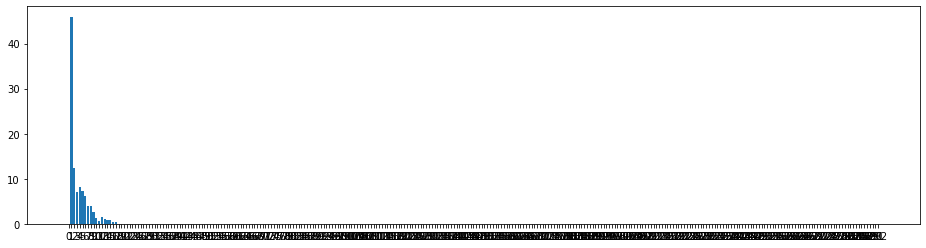

In [125]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
values_str = []
timeline_ts = [0]*len(values_int)
prev = 0
for i in values_int:
    values_str.append(str(i))
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i]) & fread_condition
    timeline_ts[i] = io_ddf_read_write[contains]['size'].sum()/1024.0/1024.0/1024.0
    prev = values[i]
plt.figure(figsize=(16,4))
print(timeline_ts)
plt.bar(values_str, timeline_ts)
plt.show()

[0.0, 12.991534440778196, 0.9587642746046185, 0.4764997959136963, 0.6929594278335571, 0.9922993183135986, 0.5588650703430176, 0.40933728218078613, 0.3837168216705322, 0.26216447353363037, 0.26366114616394043, 0.05321502685546875, 0.1775836944580078, 0.18710017204284668, 0.1045846939086914, 0.1071542501449585, 0.03802299499511719, 0.017251968383789062, 0.09892523288726807, 0.19823670387268066, 0.0, 0.0, 0.09904325008392334, 0.19682049751281738, 0.028780102729797363, 0.0, 0.05293607711791992, 0.09892523288726807, 0.09873747825622559, 0.0, 0.05346715450286865, 0.0, 0.19755005836486816, 0.0, 0.052919983863830566, 0.0, 0.19701361656188965, 0.0, 0.05293607711791992, 0.0, 0.09977281093597412, 0.0980454683303833, 0.09877502918243408, 0.0, 0.0, 0.25140881538391113, 0.0, 0.05333304405212402, 0.0, 0.0980079174041748, 0.05331158638000488, 0.09789526462554932, 0.053386688232421875, 0.0, 0.09908080101013184, 0.09789526462554932, 0.09797036647796631, 0.0, 0.09777724742889404, 0.0, 0.15083134174346924

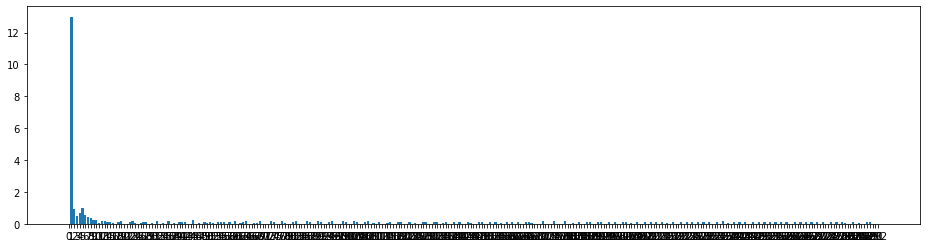

In [126]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
values_str = []
timeline_ts = [0]*len(values_int)
prev = 0
for i in values_int:
    values_str.append(str(i))
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i]) & fwrite_condition
    timeline_ts[i] = io_ddf_read_write[contains]['size'].sum()/1024.0/1024.0/1024.0
    prev = values[i]
plt.figure(figsize=(16,4))
print(timeline_ts)
plt.bar(values_str, timeline_ts)
plt.show()

**Most of the I/O (20GB) is performed in first 40 seconds and rest 1GB happens in the rest of the time**

### Time Timeline

[0.0, 73.85513, 18.08545, 10.933914, 12.151215, 11.169312, 9.228088, 5.786621, 5.7680054, 3.571045, 2.2001343, 1.1245117, 2.0100098, 1.5023193, 1.2055664, 1.0965576, 0.5300293, 0.48815918, 0.111328125, 0.20178223, 0.0, 0.0, 0.10522461, 0.21875, 0.036376953, 0.0, 0.05517578, 0.1003418, 0.099609375, 0.0, 0.059570312, 0.0, 0.19897461, 0.0, 0.11767578, 0.0, 0.20117188, 0.0, 0.060302734, 0.0, 0.0949707, 0.10449219, 0.10644531, 0.0, 0.0, 0.2524414, 0.0, 0.068847656, 0.0, 0.115234375, 0.092285156, 0.1015625, 0.1665039, 0.0, 0.091796875, 0.09326172, 0.11328125, 0.0, 0.109375, 0.0, 0.1743164, 0.0, 0.06347656, 0.09667969, 0.23925781, 0.0, 0.0, 0.057128906, 0.06298828, 0.1694336, 0.0, 0.0, 0.0, 0.19677734, 0.11376953, 0.0, 0.0, 0.20996094, 0.052246094, 0.0, 0.0, 0.09765625, 0.19628906, 0.0, 0.0, 0.0, 0.21484375, 0.10644531, 0.0, 0.0, 0.19335938, 0.10253906, 0.0, 0.0, 0.10058594, 0.19140625, 0.0, 0.0, 0.0, 0.15234375, 0.09765625, 0.0, 0.0, 0.203125, 0.09667969, 0.0, 0.0, 0.08691406, 0.41210938, 0.

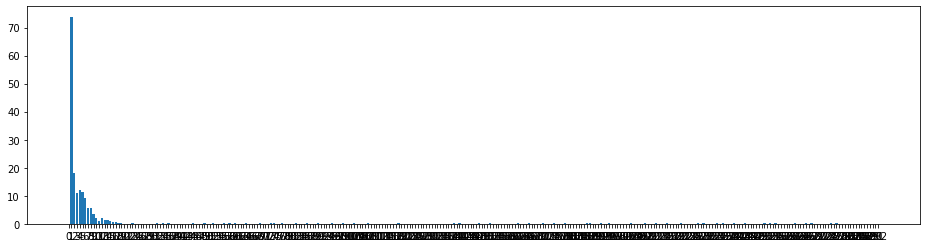

In [83]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
timeline_ts = [0]*len(values_int)
prev = 0
values_str = []
for i in values_int:
    values_str.append(str(i))
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i])
    timeline_ts[i] = io_ddf_read_write[contains]['duration'].sum()
    prev = values[i]
plt.figure(figsize=(16,4))
print(timeline_ts)
plt.bar(values_str, timeline_ts)
plt.show()

#### Bandwidth Timeline

[nan, 0.9273582955332818, 0.7417043510097969, 0.4239223087518104, 0.23029912493915436, 0.22583378344456947, 0.06199816488062598, 0.05556951330378478, 0.05311193279857164, 0.05489616271442795, 0.04564197124080897, 0.02578678333984381, 0.01334181385042787, 0.013934836829282156, 0.012421555473428143, 0.014471848031450695, 0.011198907092038366, 0.016746422433244958, 0.008963382434634628, 0.009524311106358766, nan, nan, 0.002475826589591441, 0.0024988822938191387, 0.0008649742567455572, nan, 0.0006409951057033739, 0.002196166826331097, 0.002402200208068644, nan, 0.002595876525615998, nan, 0.0022110072520429283, nan, 0.002150399764854047, nan, 0.002399586926681591, nan, 0.0026475656478800237, nan, 0.002175246947273018, 0.002563066210882596, 0.0006211750458008358, nan, nan, 0.00043297952633883623, nan, 0.00023098016955424623, nan, 0.0006466045860542862, 0.0005467377366148387, 0.0005481856099397113, 0.00023705176052691304, nan, 0.0005454714026643405, 0.0005226292893385148, 0.000528779085666078

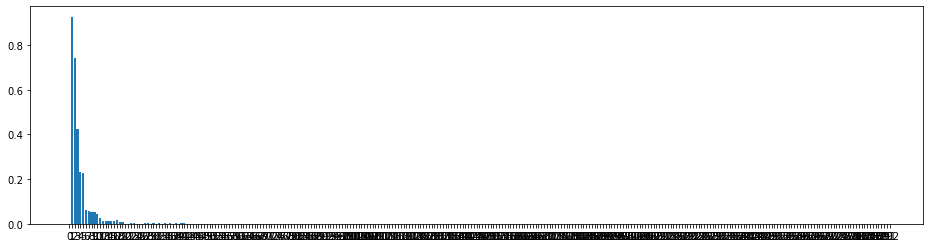

In [124]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
timeline_ts = [0]*len(values_int)
prev = 0
values_str = []
for i in values_int:
    values_str.append(str(i))
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i])
    timeline_ts[i] = io_ddf_read_write[contains]['bandwidth'].mean()/1024.0
    prev = values[i]
plt.figure(figsize=(16,4))
print(timeline_ts)
plt.bar(values_str, timeline_ts)
plt.show()

[nan, 1.1837904751927832, 0.9493221538996629, 0.5442355649936609, 0.31346906095329435, 0.3076242727395865, 0.08551261496821344, 0.0723092968954193, 0.07661670871439558, 0.07620589926697342, 0.06956211363734345, 0.030368419100498624, 0.02003122047625248, 0.017704679283839977, 0.020336037306537984, 0.01868979334683123, 0.018063215903874726, 0.021778833229645418, 0.02003851647944918, 0.04056268510162963, nan, nan, 0.0074884827785228255, 0.010762123226195342, 0.004755438929018767, nan, 0.0033804581804973326, 0.005777128352675327, 0.008561648190293682, nan, 0.009072606281567645, nan, 0.006972522926924344, nan, 0.006351119509626015, nan, 0.008928574402994249, nan, 0.007042289339880429, nan, 0.006780705361996057, 0.01269535223642985, 0.0022823140862282742, nan, nan, 0.001987722100690994, nan, 0.0021269683438445886, nan, 0.0024986697497228903, 0.0015772376455464997, 0.001502630782085331, 0.002327209221728464, nan, 0.002170143304047761, 0.001562502384185791, 0.0014808755171926398, nan, 0.001562

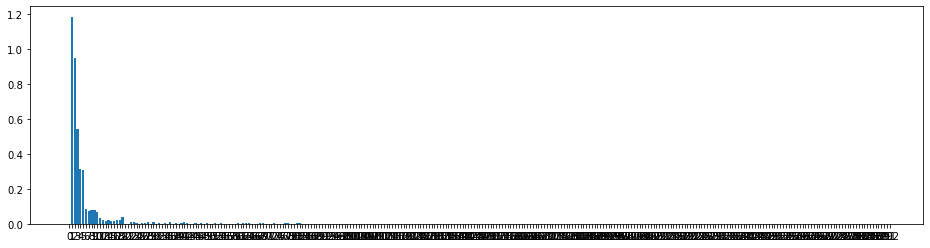

In [127]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
timeline_ts = [0]*len(values_int)
prev = 0
values_str = []
for i in values_int:
    values_str.append(str(i))
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i]) & fread_condition
    timeline_ts[i] = io_ddf_read_write[contains]['bandwidth'].mean()/1024.0
    prev = values[i]
plt.figure(figsize=(16,4))
print(timeline_ts)
plt.bar(values_str, timeline_ts)
plt.show()

[nan, 0.5463714421461586, 0.12306110085048023, 0.053307688810810466, 0.028227027663799507, 0.051920549433689456, 0.008236758964482213, 0.012842493956465804, 0.005698446472849877, 0.007323200987371361, 0.011126676142217582, 0.003956155215992647, 0.0014046758102288445, 0.005791066962981892, 0.0011108178666983397, 0.004298221870845796, 0.00047197191225486736, 0.0005272253235774254, 0.008492555480072463, 0.008292391131715876, nan, nan, 0.0022651455140543287, 0.002155545391613924, 0.0006101342782128871, nan, 0.0005315447197488306, 0.002048477064550163, 0.002141941842622516, nan, 0.002170498088254767, nan, 0.0020217381496631377, nan, 0.0018822992214163822, nan, 0.002146716998216366, nan, 0.002310726444426952, nan, 0.001987630270885377, 0.0021848782410332428, 0.0005641484789356316, nan, nan, 0.00037059145110645935, nan, 0.00016062195286696134, nan, 0.0005742076397498542, 0.000461578369140625, 0.0005131855832545111, 0.00016505659696775375, nan, 0.00047752771811471445, 0.000482277209600553, 0.0

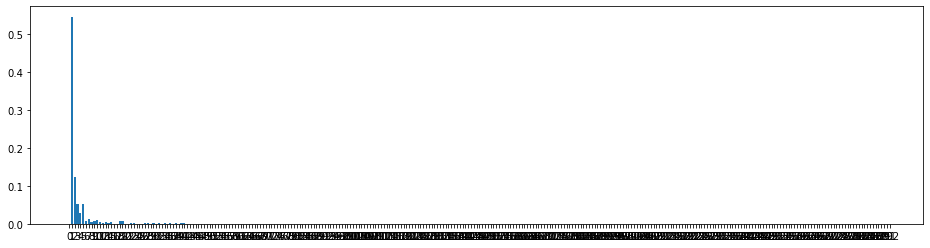

In [128]:
import math
values = np.arange(0, math.ceil(job_time), time_step)
values_int = range(len(values))
timeline_ts = [0]*len(values_int)
prev = 0
values_str = []
for i in values_int:
    values_str.append(str(i))
    contains = (io_ddf_read_write['tstart'] >=prev) & (io_ddf_read_write['tend'] <values[i]) & fwrite_condition
    timeline_ts[i] = io_ddf_read_write[contains]['bandwidth'].mean()/1024.0
    prev = values[i]
plt.figure(figsize=(16,4))
print(timeline_ts)
plt.bar(values_str, timeline_ts)
plt.show()

**This supports our previous observation as the bandwidth is the measure of I/O performance of the application.**

#### Bandwidth Timeline Per Rank

app mProject


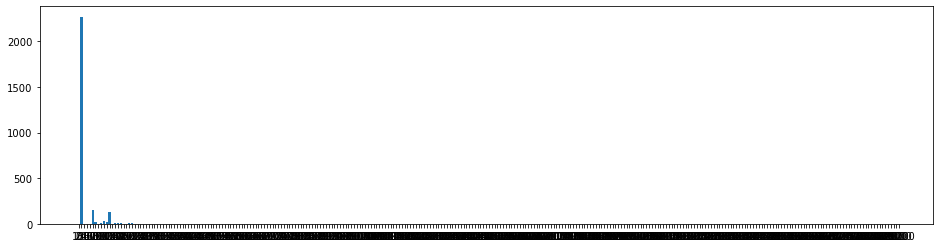

app mDiff


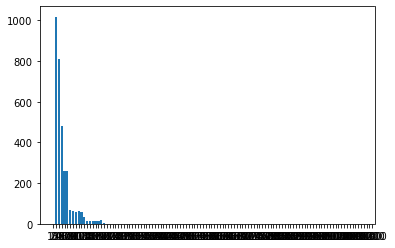

app mFitplane


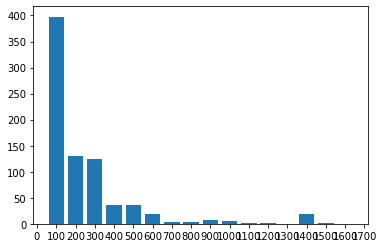

app mBackground


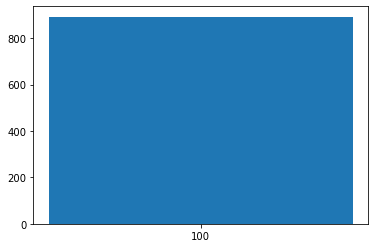

app mConcatFit


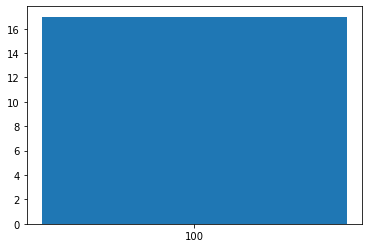

app mViewer


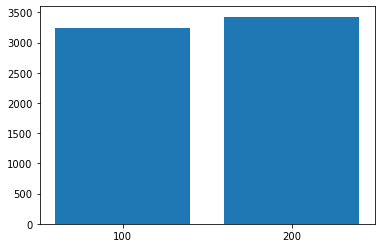

app mImgtbl


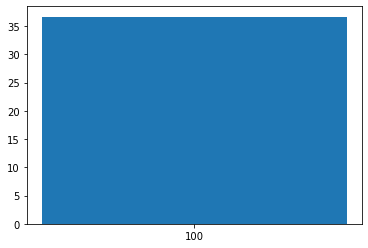

app mAdd


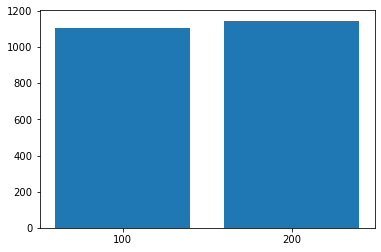

app mBgModel


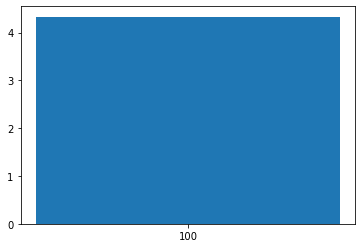

In [85]:
import math

selected_app = io_ddf_read_write['app'].unique()

plt.figure(figsize=(16,4))
for app in selected_app:
    io_df_rank = io_ddf_read_write[io_ddf_read_write['app'] == app]
    values = np.arange(0, math.ceil(job_time), time_step)
    values_int = range(len(values))
    timeline_ts = [0]*len(values_int)
    value_str = []
    prev = 0
    for i in values_int:
        value_str.append(str(values[i]))
        contains = (io_df_rank['tstart'] >=prev) & (io_df_rank['tend'] <values[i])
        timeline_ts[i] = io_df_rank[contains]['bandwidth'].mean()
        prev = values[i]
    print("app {}".format(app))
    plt.bar(value_str, timeline_ts)
    plt.show()

**Most I/O happens in the first 40 sec and most bandwidth is achieved from PFS**

#### Request Size Timeline per Rank

app mProject


<Figure size 1152x288 with 0 Axes>

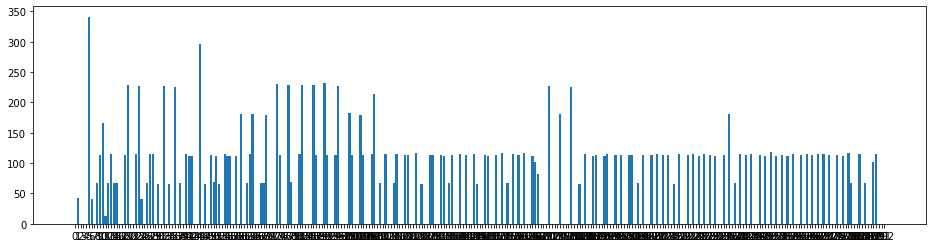

app mDiff


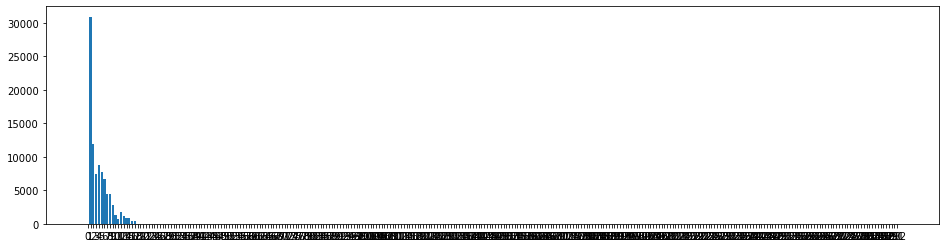

app mFitplane


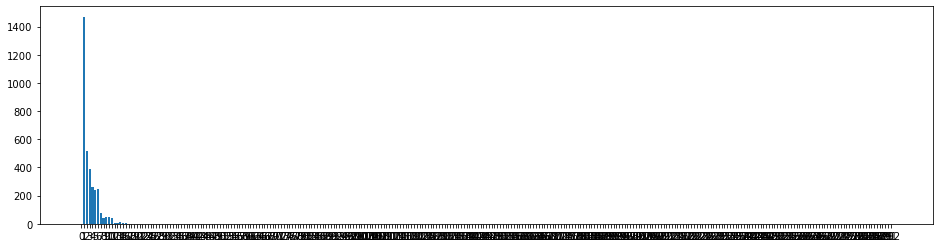

app mBackground


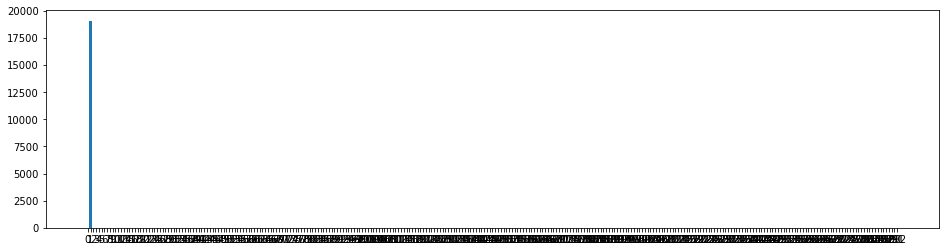

app mConcatFit


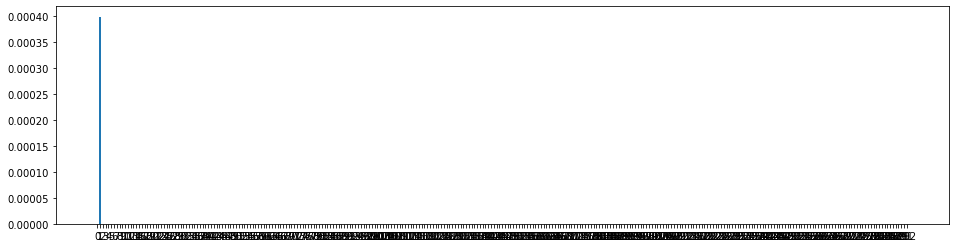

app mViewer


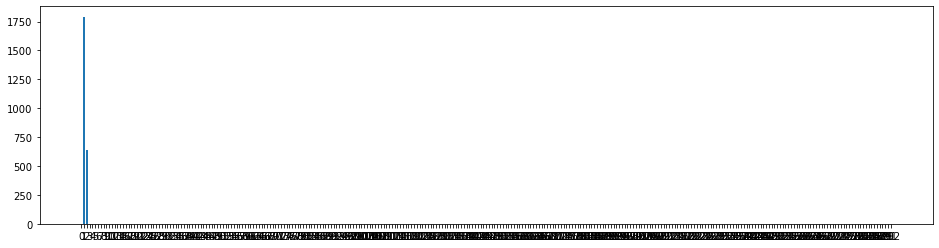

app mImgtbl


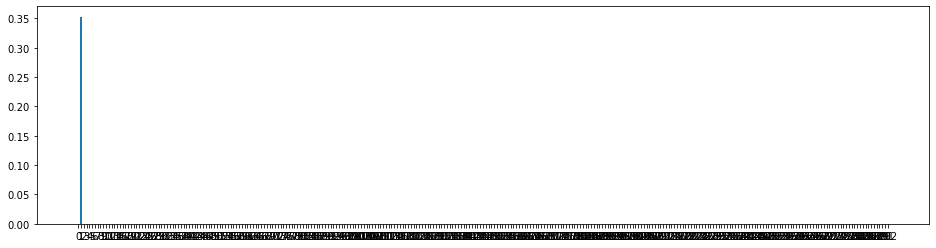

app mAdd


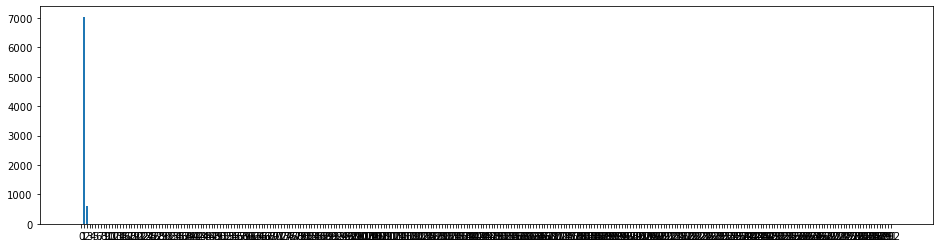

app mBgModel


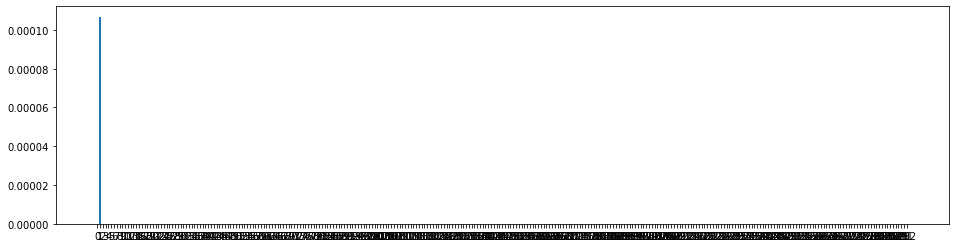

In [86]:
import math
selected_app = io_ddf_read_write['app'].unique()

plt.figure(figsize=(16,4))
for app in selected_app:
    io_df_rank = io_ddf_read_write[io_ddf_read_write['app'] == app]
    values = np.arange(0, math.ceil(job_time), time_step)
    values_int = range(len(values))
    timeline_ts = [0]*len(values_int)
    value_str = []
    prev = 0
    for i in values_int:
        value_str.append(str(i))
        contains = (io_df_rank['tstart'] >=prev) & (io_df_rank['tend'] <values[i])
        timeline_ts[i] = io_df_rank[contains]['size'].sum()/1024.0/1024.0
        prev = values[i]
    print("app {}".format(app))
    plt.figure(figsize=(16,4))
    plt.bar(value_str, timeline_ts)
    plt.show()

**Only rank 0 does I/O throughout the time. Rest perform read in first 40 seconds and perform computations.** 

## Find file which are independent or shared
- Make all thread id start from 0 and unique across ranks
- Group by filename nunique thread_id
- Find all filename with nunique > 1

In [87]:
thread_index_series = io_ddf.groupby(['proc', 'thread_id'])['thread_id'].nunique().cumsum().compute()

In [88]:
proc_index_series = io_ddf.groupby(['hostname','proc'])['thread_id'].nunique().cumsum().compute()

In [89]:
#io_ddf['thread_index'] = 0
#for index,item in thread_index_series.iteritems():
#    condition = (io_ddf['proc'] == index[0]) & (io_ddf['thread_id'] == index[1])
#    io_ddf['thread_index'] = io_ddf['thread_index'].mask(condition , item - 1)

In [90]:
num_procs = proc_index_series.count()
threads = thread_index_series.count()
print("We have {} threads across {} process".format(threads, num_procs))

We have 11231 threads across 11360 process


In [91]:
filename_series = io_ddf[io_ddf['filename'].str.contains('/p/gpfs1')].groupby(['filename'])['proc'].nunique().compute()

In [92]:
independent_files = filename_series[filename_series == 1]
print("{} files that are accessed by application by only one rank".format(len(independent_files)))

4778 files that are accessed by application by only one rank


In [93]:
shared_files = filename_series[filename_series > 1]
print("{} files that are accessed by application by more than one rank".format(len(shared_files)))

960 files that are accessed by application by more than one rank


This application doesnt share files. That is it follows a File per process pattern.

### Data Flow
We plot how different ranks in the job are accessing data.

In [94]:
io_ddf_read_write['file_type'] = io_ddf_read_write['filename'] 
io_ddf_read_write['file_type'] = io_ddf_read_write['file_type'].apply(lambda x: x.split('/')[-1])
io_ddf_read_write['file_type'] = io_ddf_read_write['file_type'].apply(lambda x: x.split('_')[0])
io_ddf_read_write['file_type'] = io_ddf_read_write['file_type'].apply(lambda x: x.split('.')[0] + "*") # keep first part of dot
io_ddf_read_write['file_type'] = io_ddf_read_write['file_type'].apply(lambda x: x.split('-')[1] if '-' in x else x)
                              

In [95]:
io_ddf_read_write

,index,proc,rank,thread_id,cat,tstart,tend,func_id,level,hostname,...,args_7,args_8,args_9,args_10,duration,filename,size,count,bandwidth,file_type
1,2,120324,0,321552,0,434.451538,434.451752,fread,0,lassen76,...,,,,,0.000214,/p/gpfs1/haridev/iopp/montage-workflow/scratch...,2,1,0.008929,poss2ukstu*
4,5,120324,0,321552,0,434.451874,434.451904,fread,0,lassen76,...,,,,,0.000031,/p/gpfs1/haridev/iopp/montage-workflow/scratch...,2,1,0.062500,poss2ukstu*
7,8,120324,0,321552,0,434.454681,434.454681,fread,0,lassen76,...,,,,,0.000000,/p/gpfs1/haridev/iopp/montage-workflow/scratch...,4,1,0.000000,poss2ukstu*
9,10,120324,0,321552,0,434.454742,434.454773,fread,0,lassen76,...,,,,,0.000031,/p/gpfs1/haridev/iopp/montage-workflow/scratch...,32768,1,1024.000000,poss2ukstu*
10,11,120324,0,321552,0,434.455536,434.455566,fread,0,lassen76,...,,,,,0.000031,/p/gpfs1/haridev/iopp/montage-workflow/scratch...,32768,1,1024.000000,poss2ukstu*
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,20,63543,0,321552,0,67.868149,67.868156,fread,0,lassen734,...,,,,,0.000008,/p/gpfs1/haridev/iopp/montage-workflow/scratch...,2880,1,360.000000,pposs2ukstu*
23,24,63543,0,321552,0,67.868301,67.868324,fread,0,lassen734,...,,,,,0.000023,/p/gpfs1/haridev/iopp/montage-workflow/scratch...,2,1,0.083333,pposs2ukstu*
26,27,63543,0,321552,0,67.868439,67.868446,fread,0,lassen734,...,,,,,0.000008,/p/gpfs1/haridev/iopp/montage-workflow/scratch...,2880,1,360.000000,pposs2ukstu*
28,29,63543,0,321552,0,67.868546,67.868561,fread,0,lassen734,...,,,,,0.000015,/p/gpfs1/haridev/iopp/montage-workflow/scratch...,2,1,0.125000,pposs2ukstu*


In [96]:
#call_series = io_ddf_read_write.groupby(['hostname','app','proc','func_id','file_type']).agg({'size': ['sum','count']})
call_series = io_ddf_read_write.groupby(['app','func_id','file_type']).agg({'size': ['sum','count'], 'proc':['nunique'], 'tstart':['min'], 'tend':['max'], 'duration':['sum']}).sort_values(by=[('tstart','min')])

In [97]:
call_series

size             proc      tstart  \
                                           sum    count nunique         min   
app         func_id file_type                                                 
mDiff       fread   oversized*    1.537835e+07    10672    5271    0.002796   
mFitplane   fread   diff*         3.578590e+09   857791     415    0.003119   
mDiff       fread   pposs2ukstu*  8.952759e+10  4389680    5271    0.007973   
            fwrite  diff*         7.366067e+09  1907844     420    0.850141   
            fread   diff*         2.027520e+06      704     352    0.865736   
mProject    fread   poss2ukstu*   2.240434e+09    69554     169    1.292803   
mBackground fread   pposs2ukstu*  1.001111e+10   518248     108    1.494784   
mProject    fread   oversized*    4.870580e+05      338     169    1.536754   
mConcatFit  fwrite  fits*         4.180000e+02        2       2    1.543194   
mBackground fwrite  cposs2ukstu*  1.001082e+10  1046902     108    1.939872   
mViewer     fread   mosaic*       2.488332e+09    43208       2    5.482609   
mBackground fread   cposs2ukstu*  1.670400e+05       58      29    8.023874   
mBgModel    fwrite  corrections*  1.120000e+02        2       2   18.638039   
mViewer     fwrite  mosaic*       6.265667e+07        2       2   59.857700   
mImgtbl     fread   cposs2ukstu*  3.688960e+05      256       2   73.618073   
            fwrite  updated       1.030000e+03       14       2   73.635490   
mAdd        fread   region*       5.764000e+03        4       2   80.607735   
                    cposs2ukstu*  6.369049e+09   328942       2   80.766029   
            fwrite  mosaic*       1.658892e+09   172804       2   82.015450   
            fread   mosaic*       1.152000e+04        4       2   98.151169   
mProject    fwrite  pposs2ukstu*  1.596808e+10  1661266     169  431.298096   
            fread   pposs2ukstu*  2.649600e+05       92      46  748.552246   

                                          tend    duration  
                                           max         sum  
app         func_id file_type                               
mDiff       fread   oversized*    10714.381836    0.159741  
mFitplane   fread   diff*          1530.981323    3.913514  
mDiff       fread   pposs2ukstu*  10714.601562  119.634918  
            fwrite  diff*          1686.419922    8.417613  
            fread   diff*          1686.419678    0.014008  
mProject    fread   poss2ukstu*   28853.498047    1.379301  
mBackground fread   pposs2ukstu*     76.672821    9.040470  
mProject    fread   oversized*    28853.287109    0.004238  
mConcatFit  fwrite  fits*            45.283974    0.000023  
mBackground fwrite  cposs2ukstu*     76.810860    9.039318  
mViewer     fread   mosaic*         136.107468    0.861781  
mBackground fread   cposs2ukstu*     76.810829    0.672439  
mBgModel    fwrite  corrections*     62.156467    0.000025  
mViewer     fwrite  mosaic*         165.738556    0.006008  
mImgtbl     fread   cposs2ukstu*     84.625183    0.759651  
            fwrite  updated          77.110229    0.000023  
mAdd        fread   region*          84.686432    0.000053  
                    cposs2ukstu*    102.467842    6.026588  
            fwrite  mosaic*         102.479713    1.218849  
            fread   mosaic*         102.479698    0.010742  
mProject    fwrite  pposs2ukstu*  29283.226562   14.225494  
            fread   pposs2ukstu*  28851.638672    1.052856

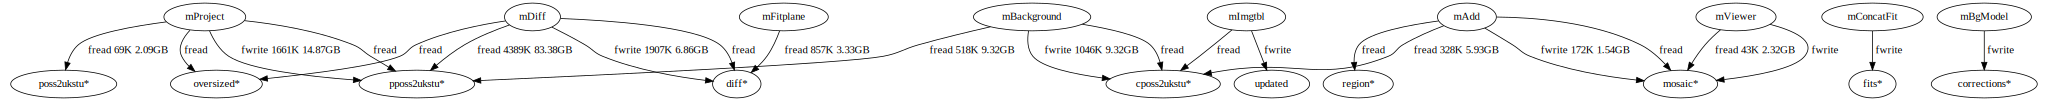

In [98]:
import graphviz
dot = graphviz.Digraph()
dot.attr(ordering="out")
for index, value in call_series.iterrows():
    #for v1, v2 in call_series.iteritems():
    #print( value)
    #value = v2.index[0]
    #index = v2.index[0]
    node_str = index[0] #+ " " + str(value[2])
    file_node_str = index[2]
    func_node_str = index[1]
    dot.node(node_str)
    dot.node(file_node_str)
    #dot.node(func_node_str)
    if value[0] > 1024.0 * 1024.0* 1024.0:
        dot.edge(node_str, file_node_str, label=func_node_str + " "+ "{}K".format(int(value[1]/1000.0)) + " " + "{:0.2f}GB".format(value[0]/1024.0/1024.0/1024.0))
    else:
        dot.edge(node_str, file_node_str, label=func_node_str)
#     if "read" in func_node_str:
#         dot.edge(file_node_str, func_node_str, label=str(value[0]/1024.0) + "KB")
#     else:
#         dot.edge(func_node_str,file_node_str, label=str(value[0]/1024.0)+ "KB")

a = graphviz.Digraph('app')
a.attr(rank='same')
a.attr(ordering="out")
for index, value in call_series.iterrows():
    node_str = index[0]
    a.node(node_str)

# o = graphviz.Digraph('func')
# o.attr(rank='same')
# for index, value in call_series.iterrows():
#     node_str = index[1]
#     o.node(node_str)
    
f = graphviz.Digraph('file')
f.attr(rank='same')
for index, value in call_series.iterrows():
    node_str = index[2]
    f.node(node_str)
    
dot.subgraph(a)
# dot.subgraph(o)
dot.subgraph(f)
dot

In [99]:
import graphviz
dot = graphviz.Digraph()
selected_indices = range(1)
for selected_index in selected_indices:
    selected_shared_file = shared_files.index[selected_index]
    io_access_rank = io_ddf[io_ddf['filename'] == selected_shared_file].groupby(['app','func_id'])['func_id'].count().compute()
    dot.node(selected_shared_file)
    for index,item in io_access_rank.iteritems():
        rank = index[0]
        func_id = index[1]
        count = item
        dot.node(str(rank))
        dot.node(func_id)
        dot.edge(str(rank),func_id)
        if "read" in func_id:
            dot.edge(selected_shared_file, func_id, label=str(count))
        else:
            dot.edge(func_id,selected_shared_file, label=str(count))

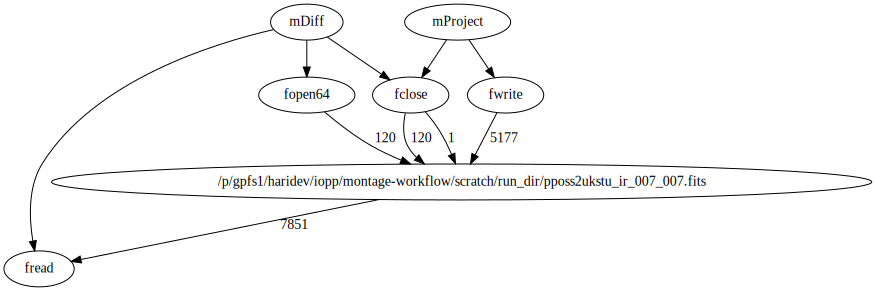

In [100]:
dot

In [101]:
import graphviz
dot = graphviz.Digraph()
selected_indices = [0]
for selected_index in selected_indices:
    if len(independent_files) > selected_index:
        selected_file = independent_files.index[selected_index]
        io_access_rank = io_ddf[io_ddf['filename'] == selected_file].groupby(['app','func_id'])['func_id'].count().compute()
        dot.node(selected_file)
        for index,item in io_access_rank.iteritems():
            rank = index[0]
            func_id = index[1]
            count = item
            dot.node(str(rank))
            dot.node(func_id)
            dot.edge(str(rank),func_id)
            if "read" in func_id:
                dot.edge(selected_file, func_id, label=str(count))
            else:
                dot.edge(func_id,selected_file, label=str(count))

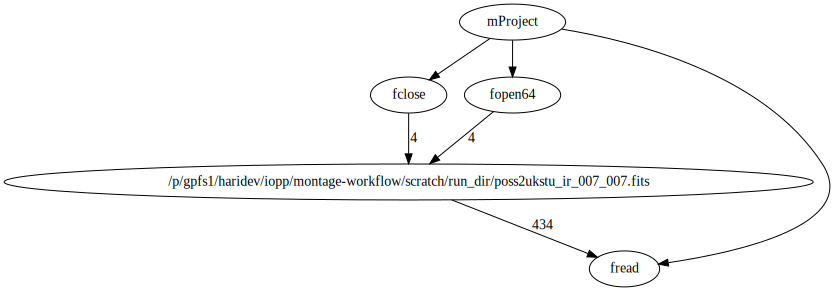

In [102]:
dot

## Calculate Access Pattern
- Calculate segment_index
  - select file_ptr based on open flag
  - update file_ptr based on operation
  - do a cum_sum on file_ptr to calculate final file_ptr
  - assign segment_index based on granularity (median transfer size)
- isolate segment index into
  - sequential flag if segment index is increasing
  - consequitive flag if segment index is increasing and one after the other

#### Persist the current version of I/O dataframe.

In [103]:
io_ddf = io_ddf.persist()
result = wait(io_ddf)

### Select files which have no seeks and those which have

In [104]:
files_with_seek = io_ddf[io_ddf['func_id'].str.contains('seek') & io_ddf['filename'].str.contains('/p/gpfs')]['filename'].unique().compute()
print("{} files have seek operations".format(len(files_with_seek)))

0 files have seek operations


In [105]:
files_with_seek

Series([], Name: filename, dtype: object)

In [106]:
all_filenames

0       /p/gpfs1/haridev/iopp/montage-workflow/scratch...
1       /p/gpfs1/haridev/iopp/montage-workflow/scratch...
2       /p/gpfs1/haridev/iopp/montage-workflow/scratch...
3       /p/gpfs1/haridev/iopp/montage-workflow/scratch...
4       /p/gpfs1/haridev/iopp/montage-workflow/scratch...
                              ...                        
5733    /p/gpfs1/haridev/iopp/montage-workflow/scratch...
5734    /p/gpfs1/haridev/iopp/montage-workflow/scratch...
5735    /p/gpfs1/haridev/iopp/montage-workflow/scratch...
5736    /p/gpfs1/haridev/iopp/montage-workflow/scratch...
5737    /p/gpfs1/haridev/iopp/montage-workflow/scratch...
Name: filename, Length: 5738, dtype: object

In [107]:
files_without_seek = set(all_filenames) - set(files_with_seek)
print("{} files have no seek operations and hence are sequential".format(len(files_without_seek)))

5738 files have no seek operations and hence are sequential


### Per File Analysis
- Total I/O amount
- Total I/O time (average per process)
- Average Bandwidth
- I/O Request Distribution

In [108]:
per_file_size = io_ddf_read_write.groupby(['filename'])['size'].sum()
per_file_size = per_file_size / 1024.0/1024.0
per_file_size = per_file_size.sort_values(ascending=False)
per_file_size.head(5)

filename
/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/3-mosaic.fits                       1582.042240
/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/2-mosaic.fits                       1582.042240
/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/pposs2ukstu_ir_002_006_area.fits     506.465397
/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/pposs2ukstu_ir_002_006.fits          506.465397
/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/pposs2ukstu_ir_002_005.fits          506.076000
Name: size, dtype: float64

In [109]:
per_file_time = io_ddf_read_write.groupby(['filename'])['duration'].sum().sort_values(ascending=False)
per_file_time.head(5)

filename
/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/3-mosaic.fits                       0.815249
/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/pposs2ukstu_ir_002_006.fits         0.713469
/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/pposs2ukstu_ir_002_005.fits         0.684066
/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/pposs2ukstu_ir_002_006_area.fits    0.683456
/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/pposs2ukstu_red_003_004.fits        0.677725
Name: duration, dtype: float32

In [110]:
per_file_bw = io_ddf_read_write.groupby(['filename'])['bandwidth'].sum().sort_values(ascending=True)
per_file_bw.head(5)

filename
/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/poss2ukstu_red_008_005.fits     0.000000
/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/poss2ukstu_blue_001_003.fits    0.000977
/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/cposs2ukstu_ir_001_001.fits     0.422069
/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/cposs2ukstu_ir_007_007.fits     0.456013
/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/cposs2ukstu_ir_005_001.fits     0.519952
Name: bandwidth, dtype: float64

In [111]:
import graphviz
dot = graphviz.Digraph()
selected_indices = [0]
for selected_index in selected_indices:
    selected_file = per_file_size.index[selected_index]
    io_access_rank = io_ddf[io_ddf['filename'] == selected_file].groupby(['app','func_id'])['func_id'].count().compute()
    dot.node(selected_file)
    for index,item in io_access_rank.iteritems():
        rank = index[0]
        func_id = index[1]
        count = item
        if "read" in func_id or "write" in func_id:
            dot.node(str(rank))
            dot.node(func_id)
            dot.edge(str(rank),func_id)
            if "read" in func_id:
                dot.edge(selected_file, func_id, label=str(count))
            elif "write" in func_id:
                dot.edge(func_id,selected_file, label=str(count))

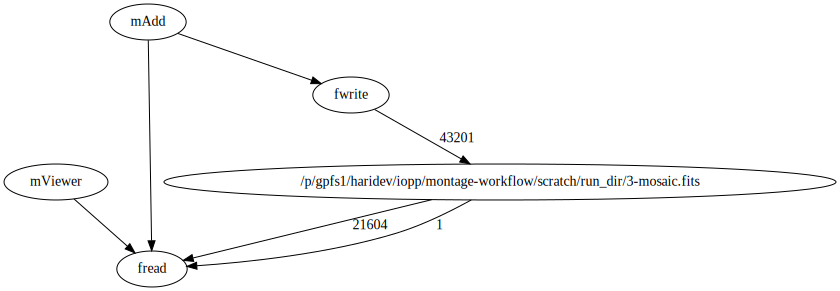

In [112]:
dot

In [113]:
import graphviz
dot = graphviz.Digraph()
selected_indices = [0]
for selected_index in selected_indices:
    selected_file = per_file_time.index[selected_index]
    io_access_rank = io_ddf[io_ddf['filename'] == selected_file].groupby(['app','func_id'])['func_id'].count().compute()
    dot.node(selected_file)
    for index,item in io_access_rank.iteritems():
        rank = index[0]
        func_id = index[1]
        count = item
        dot.node(str(rank))
        dot.node(func_id)
        dot.edge(str(rank),func_id)
        if "read" in func_id:
            dot.edge(selected_file, func_id, label=str(count))
        else:
            dot.edge(func_id,selected_file, label=str(count))

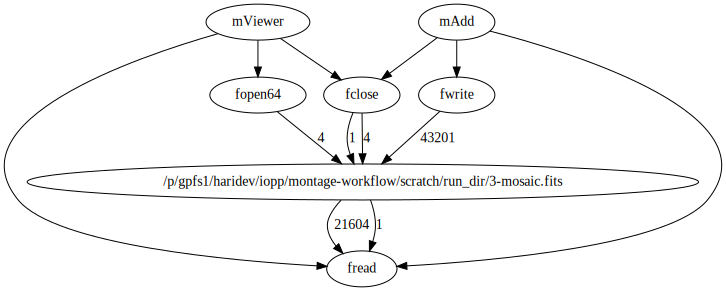

In [114]:
dot

In [115]:
import graphviz
dot = graphviz.Digraph()
selected_indices = range(5)
for selected_index in selected_indices:
    selected_file = per_file_bw.index[selected_index]
    io_access_rank = io_ddf[io_ddf['filename'] == selected_file].groupby(['app','func_id'])['func_id'].count().compute()
    dot.node(selected_file)
    for index,item in io_access_rank.iteritems():
        rank = index[0]
        func_id = index[1]
        count = item
        dot.node(str(rank))
        dot.node(func_id)
        dot.edge(str(rank),func_id)
        if "read" in func_id:
            dot.edge(selected_file, func_id, label=str(count))
        else:
            dot.edge(func_id,selected_file, label=str(count))

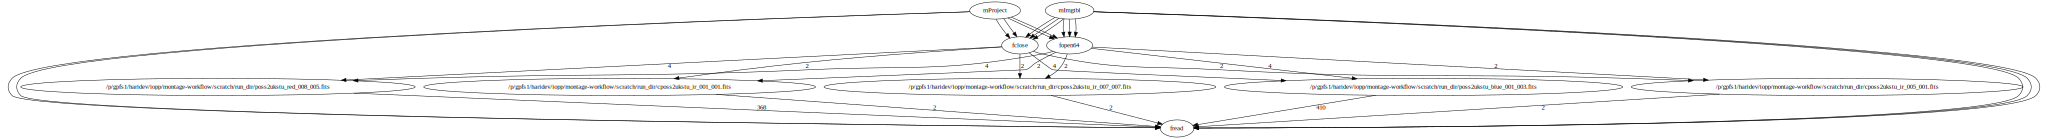

In [116]:
dot

In [117]:
write_files = io_ddf_read_write[io_ddf_read_write['func_id'].str.contains('write')]['filename'].unique()
read_files = io_ddf_read_write[io_ddf_read_write['func_id'].str.contains('read')]['filename'].unique()
read_only_files = set(all_filenames) - set(write_files)
write_only_files = set(all_filenames) - set(read_files)
print("{} files are written into.\n{} file are read from.\n{} files are write-only.\n{} file are read-only."
      .format(len(write_files), len(read_files), len(write_only_files), len(read_only_files)))

1406 files are written into.
1581 file are read from.
4157 files are write-only.
4332 file are read-only.


In [118]:
print(read_only_files)

{'/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/2-fit.000008.000013.txt', '/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/2-fit.000019.000040.txt', '/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/poss2ukstu_ir_001_003.fits', '/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/3-fit.000008.000045.txt', '/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/3-fit.000024.000058.txt', '/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/3-fit.000003.000032.txt', '/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/2-fit.000021.000040.txt', '/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/2-fit.000002.000023.txt', '/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/3-fit.000011.000051.txt', '/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/3-fit.000032.000063.txt', '/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/3-fit.000033.000051.txt', '/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/2-fit.000002.000018.txt', '/p/gpfs1/ha

In [119]:
io_per_file = io_ddf_read_write[io_ddf_read_write['filename'].isin(read_only_files)].groupby(['filename'])['size'].sum()
io_per_file = io_per_file / 1024.0/1024.0
print(io_per_file)

filename
/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/1-diff.000004.000012.fits             15.136415
/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/1-diff.000014.000021.fits              4.430239
/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/1-diff.000020.000029.fits              4.419252
/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/1-diff.000022.000029.fits              4.424746
/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/1-diff.000036.000043.fits              4.427492
                                                                                               ...    
/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/pposs2ukstu_red_007_001_area.fits    208.300962
/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/pposs2ukstu_red_007_005.fits         300.966532
/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/pposs2ukstu_red_007_005_area.fits    300.966532
/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/region-ov

In [120]:
io_per_file = io_ddf_read_write[io_ddf_read_write['filename'].isin(write_files) & io_ddf_read_write['func_id'].str.contains("write")].groupby(['filename'])['size'].sum()
io_per_file = io_per_file / 1024.0/1024.0
print(io_per_file.head(20))

filename
/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/1-diff.000001.000002.fits          7.709656
/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/1-diff.000001.000002_area.fits     7.709656
/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/1-diff.000001.000009.fits          7.728882
/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/1-diff.000001.000009_area.fits     7.728882
/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/1-diff.000001.000010.fits          4.427490
/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/1-diff.000001.000010_area.fits     4.427490
/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/1-diff.000002.000003.fits          7.720642
/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/1-diff.000002.000003_area.fits     7.720642
/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/1-diff.000002.000009.fits          4.441223
/p/gpfs1/haridev/iopp/montage-workflow/scratch/run_dir/1-diff.000002.000009_area.fits     4.441223
/

In [121]:
read_condition = io_ddf['func_id'].isin(["read", "pread", "pread64", "readv","fread"])
write_condition = io_ddf['func_id'].isin(["write", "pwrite", "pwrite64","writev","fwrite"])
data_ops = ['read', 'write']
total_time_io_data = io_ddf[ read_condition | write_condition ].groupby('rank')['duration'].sum().max().compute()
total_time_io_metadata = io_ddf[~(read_condition | write_condition)].groupby('rank')['duration'].sum().max().compute()
print("Time spent on data: {} sec, metadata: {} sec".format(total_time_io_data, total_time_io_metadata))

Time spent on data: 176.43765258789062 sec, metadata: 41.88929748535156 sec
